<a href="https://colab.research.google.com/github/Savitha-Devi/Audioprocessing2025/blob/main/Dereverb_Project_VPS_Day_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dry vs Reverb

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
# Dry audio: simple clean tone (sine wave)
sr = 22050  # sample rate
duration = 2.0  # seconds
t = np.linspace(0, duration, int(sr * duration), endpoint=False)
freq = 440  # A4 tone
dry_audio = 0.5 * np.sin(2 * np.pi * freq * t)


In [3]:
# Create synthetic Room Impulse Response (RIR)
rir = np.zeros_like(dry_audio)
rir[0] = 1.0
rir[500] = 0.6
rir[1000] = 0.3
rir[1500] = 0.15

In [4]:
# Apply RIR using convolution to get reverb
reverb_audio = np.convolve(dry_audio, rir)[:len(dry_audio)]

In [5]:
# Play audio
print("Dry Audio:")
display(Audio(dry_audio, rate=sr))

print("Reverberated Audio:")
display(Audio(reverb_audio, rate=sr))

Dry Audio:


Reverberated Audio:


In [6]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio


In [7]:
# Sampling rate and duration
sr = 16000
duration = 2.0  # 2 seconds

In [8]:
# Generate chirp (dry signal)
t = np.linspace(0, duration, int(sr * duration), endpoint=False)
dry_audio = librosa.chirp(fmin=200, fmax=4000, sr=sr, duration=duration)

In [9]:
# Create a realistic RIR (Room Impulse Response) - synthetic with decaying echo
rir_length = int(0.5 * sr)  # 0.5 seconds RIR
time = np.linspace(0, 1, rir_length)
rir = np.exp(-3 * time) * np.random.randn(rir_length)
rir /= np.max(np.abs(rir))  # Normalize

In [10]:
# Convolve to get reverberated signal
reverb_audio = np.convolve(dry_audio, rir, mode='full')
reverb_audio = reverb_audio[:len(dry_audio)]  # Match original length

In [11]:
# Listen
print("Dry (original) audio:")
display(Audio(dry_audio, rate=sr))

Dry (original) audio:


In [12]:
print("Reverberated audio:")
display(Audio(reverb_audio, rate=sr))

Reverberated audio:


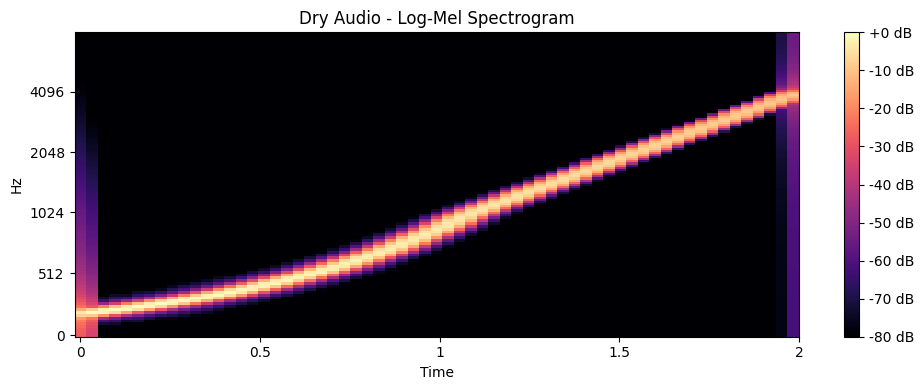

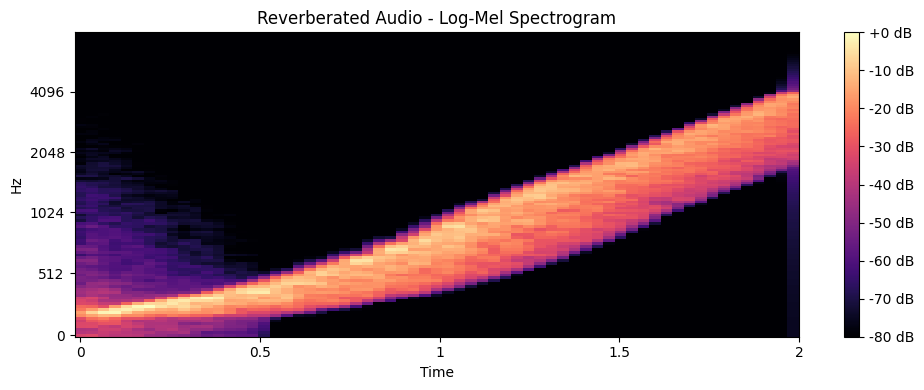

In [13]:
# Plot Spectrograms
def plot_logmel(audio, sr, title):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    logmel = librosa.power_to_db(mel, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(logmel, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_logmel(dry_audio, sr, "Dry Audio - Log-Mel Spectrogram")
plot_logmel(reverb_audio, sr, "Reverberated Audio - Log-Mel Spectrogram")

OBJECTIVE: Train a simple neural network using log-Mel spectrograms as input to classify dry vs reverb.

In [14]:
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [15]:
# ======= Preprocessing Functions =======

def extract_logmel_features(audio, sr=16000, n_mels=128, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel = librosa.power_to_db(mel_spec, ref=np.max)
    return logmel

def normalize(logmel):
    mean = np.mean(logmel)
    std = np.std(logmel)
    return (logmel - mean) / std

def prepare_input(logmel):
    return np.expand_dims(logmel, axis=-1)  # shape = (n_mels, time_frames, 1)

In [16]:
# ======= Generate Dataset =======
X = []
y = []

# Create small dataset by duplicating
for _ in range(50):
    X.append(prepare_input(normalize(extract_logmel_features(dry_audio, sr))))
    y.append(0)  # Label: Dry

    X.append(prepare_input(normalize(extract_logmel_features(reverb_audio, sr))))
    y.append(1)  # Label: Reverb

X = np.array(X)
y = np.array(y)

In [17]:
# ======= Split =======
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# ======= Model =======
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X.shape[1:]),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# ======= Train =======
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

# ======= Evaluate =======
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.2f}")

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 1.0000 - loss: 0.4092 - val_accuracy: 1.0000 - val_loss: 1.9366e-04
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 1.3502e-04 - val_accuracy: 1.0000 - val_loss: 1.1706e-06
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 1.0283e-06 - val_accuracy: 1.0000 - val_loss: 4.1436e-08
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 1.0000 - loss: 4.3372e-08 - val_accuracy: 1.0000 - val_loss: 3.8573e-09
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 1.0000 - loss: 4.2442e-09 - val_accuracy: 1.0000 - val_loss: 9.3534e-10
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 1.0000 - loss: 1.0341e-09 - val_accuracy: 1.0000 - val_loss: 3.4492e-10
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 3.8468e-10 - val_accuracy: 1.0000 - val_loss: 1.6363e-10
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.00

Utility Functions

In [20]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Extract log-mel spectrogram
def extract_logmel_features(audio, sr=22050, n_mels=128, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel = librosa.power_to_db(mel_spec, ref=np.max)
    return logmel

def normalize(logmel):
    mean = np.mean(logmel)
    std = np.std(logmel)
    return (logmel - mean) / std

def prepare_input_for_nn(logmel):
    return np.expand_dims(logmel, axis=0)  # (1, n_mels, time)

def process_audio_for_nn(audio, sr=22050):
    logmel = extract_logmel_features(audio, sr)
    norm_logmel = normalize(logmel)
    nn_input = prepare_input_for_nn(norm_logmel)
    return nn_input

Create slices from audio

In [21]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Extract log-mel spectrogram
def extract_logmel_features(audio, sr=22050, n_mels=128, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel = librosa.power_to_db(mel_spec, ref=np.max)
    return logmel

def normalize(logmel):
    mean = np.mean(logmel)
    std = np.std(logmel)
    return (logmel - mean) / std

def prepare_input_for_nn(logmel):
    return np.expand_dims(logmel, axis=0)  # (1, n_mels, time)

def process_audio_for_nn(audio, sr=22050):
    logmel = extract_logmel_features(audio, sr)
    norm_logmel = normalize(logmel)
    nn_input = prepare_input_for_nn(norm_logmel)
    return nn_input

Train-Test Spilt

In [23]:
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define & Train Neural network:


In [28]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# ---- Generate Dry and Reverb Audio ----
sr = 22050
duration = 2.0
t = np.linspace(0, duration, int(sr * duration), endpoint=False)

# Dry: pure sine wave
dry_audio = 0.5 * np.sin(2 * np.pi * 220 * t)

# Reverb: simulate by convolving with a short impulse response (echo)
impulse_response = np.zeros_like(dry_audio)
impulse_response[0] = 1
impulse_response[500] = 0.6
impulse_response[1000] = 0.3
reverb_audio = np.convolve(dry_audio, impulse_response, mode='full')[:len(dry_audio)]

# ---- Feature Extraction ----
def extract_logmel_features(audio, sr=22050, n_mels=128, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel = librosa.power_to_db(mel_spec, ref=np.max)
    return logmel

def normalize(logmel):
    return (logmel - np.mean(logmel)) / np.std(logmel)

def prepare_input_for_nn(logmel):
    return np.expand_dims(logmel, axis=0)  # shape (1, n_mels, time_frames)

def process_audio_for_nn(audio):
    logmel = extract_logmel_features(audio)
    norm_logmel = normalize(logmel)
    return prepare_input_for_nn(norm_logmel)

nn_input_dry = process_audio_for_nn(dry_audio)
nn_input_reverb = process_audio_for_nn(reverb_audio)

# ---- Data Preparation ----
X = np.array([nn_input_dry, nn_input_reverb])  # shape (2, 1, n_mels, time_frames)
y = np.array([0, 1])  # 0: dry, 1: reverb

# Duplicate to simulate more data
X = np.tile(X, (10, 1, 1, 1))  # now 20 samples
y = np.tile(y, 10)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Reshape for CNN ----
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Remove singleton if needed
if X_train.shape[1] == 1:
    X_train = np.squeeze(X_train, axis=1)
    X_test = np.squeeze(X_test, axis=1)

# Add channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# ---- CNN Model ----
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---- Train ----
history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_split=0.2)

# ---- Evaluate ----
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.5312 - loss: 0.9035 - val_accuracy: 0.2500 - val_loss: 0.7018
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3229 - loss: 0.7022 - val_accuracy: 0.7500 - val_loss: 0.6715
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2083 - loss: 0.7162 - val_accuracy: 0.2500 - val_loss: 0.7070
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5000 - loss: 0.6930 - val_accuracy: 0.7500 - val_loss: 0.6925
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5312 - loss: 0.6930 - val_accuracy: 0.7500 - val_loss: 0.6923
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5000 - loss: 0.6930 - val_accuracy: 0.7500 - val_loss: 0.6922
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5625 - loss: 0.6929 - val_accuracy: 0.7500 - val_loss: 0.6922
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5625 - loss: 0.6929 - val_accuracy: 0.7500 - val_loss: 0.6921
Epoch 9/10

In [29]:
def generate_sine_audio(freq, duration=2.0, sr=22050):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    audio = 0.5 * np.sin(2 * np.pi * freq * t)
    return audio

def simulate_reverb(audio):
    impulse_response = np.zeros_like(audio)
    impulse_response[0] = 1
    impulse_response[500] = 0.6
    impulse_response[1000] = 0.3
    reverb = np.convolve(audio, impulse_response, mode='full')[:len(audio)]
    return reverb

dry_audios = []
reverb_audios = []
for freq in np.linspace(200, 500, 30):  # 30 diverse tones
    dry = generate_sine_audio(freq)
    reverb = simulate_reverb(dry)
    dry_audios.append(process_audio_for_nn(dry))
    reverb_audios.append(process_audio_for_nn(reverb))

X = np.array(dry_audios + reverb_audios)
y = np.array([0]*len(dry_audios) + [1]*len(reverb_audios))